# DOG BREED RECOGNITION

<br>

@author: Juarez Monteiro

---

### Este Notebook terá o objetivo de extrair as *features* dos dados de Enroll e Validação (ideia para enroll)

Para isso iremos instanciar nosso modelo escolhido, gerar os DataLoaders necessários para Enroll e Treino, e por fim extrair as características do modelo. Neste problema utilizamos as 1000 features oriundas da FC da arquitetura ResNet. Mas, poderíamos ter optado por outras features ao longo da rede.

In [1]:
# regular imports
import os
import re
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import logging
import pickle
from PIL import Image
from tqdm import tqdm


# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# pytorch related imports
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import transforms
from torchvision import models
from torch.autograd import Variable

# lightning related imports
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning import Trainer


# import wandb and login
import wandb
!wandb login

wandb: Currently logged in as: jrzmnt (use `wandb login --relogin` to force relogin)


In [2]:
class DogDataset(Dataset):

    def __init__(self, file_list, class_dict, transform=None, phase=None):
        self.file_list = file_list
        self.class_dict = class_dict
        self.transform = transform
        self.phase = phase
        print(file_list[0])

    def __len__(self):
        return len(self.file_list)
    

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert('RGB')

        # Transformimg Image
        img_transformed = self.transform(img, self.phase)

        # Get Label
        label = img_path.split('\\')[0].split('-')[-1]
        label_id = self.class_dict[label]

        return img_transformed, label_id

In [3]:
class ImageTransform():

    def __init__(self, img_size=224, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):

        self.data_transform = {

            'train': transforms.Compose([
                transforms.RandomResizedCrop(img_size, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                #transforms.RandomRotation(degrees=(0, 180)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),

            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(img_size),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),

            'test': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(img_size),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            
            'train_enroll': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(img_size),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])            
            
        }

    def __call__(self, img, phase):

        return self.data_transform[phase](img)

In [4]:
class DogDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_dir: str = './../data/dogs/'):
        super().__init__()
        
        # images and dataset
        self.data_dir = data_dir
        self.train_data_dir = data_dir + 'train/'
        self.test_data_dir = data_dir + 'recognition/test/'
        self.enroll_data_dir = data_dir + 'recognition/enroll/'
        
        self.batch_size = batch_size
        self.dims = (3, 224, 224)
        self.img_size = 224
        self.num_classes = 100
        self.class_dict = {}
        self.enroll_class_dict = {}
        
        self.train_path_images = []
        self.test_path_images = []
        self.enroll_path_images = []
        self.breeds = []
        self.enroll_breeds = []

        self.train_split_path = []
        self.val_split_path = []
        self.dog_train = []
        self.dog_val = []
        self.dog_test = []
        self.dog_enroll = []
        
    def prepare_data(self):
        """Scan train_data_dir and test_data_dir to save all the train/test paths.
           It also creates train_dict to map the classes available to a scalar.
        """
        
        # Scan all train/val images
        for d in os.listdir(self.train_data_dir):
            dog_dir = os.path.join(self.train_data_dir, d)
    
            for img in os.listdir(dog_dir):
                img_path = os.path.join(dog_dir, img)
                self.train_path_images.append(img_path)
                self.breeds.append(img_path.split('\\')[0].split('-')[-1])
            
        self.breeds = set(self.breeds)
        
        for idx, breed in enumerate(self.breeds):
            self.class_dict[breed] = idx
        
        # Scan all test images
        for d in os.listdir(self.test_data_dir):
            dog_dir = os.path.join(self.test_data_dir, d)
    
            for img in os.listdir(dog_dir):
                img_path = os.path.join(dog_dir, img)
                self.test_path_images.append(img_path)
                self.enroll_breeds.append(img_path.split('\\')[0].split('-')[-1])
                
        
        self.enroll_breeds = set(self.enroll_breeds)
        
        for idx, enroll_breed in enumerate(self.enroll_breeds):
            self.enroll_class_dict[enroll_breed] = idx
        
        print(50*'-')
        print(f'Images available for train/val: {len(self.train_path_images)}')
        print(f'Classes available for train/val: {len(self.breeds)}')
        print()
        print(f'Images available for test: {len(self.test_path_images)}')
        print(50*'-')
        
        
    def prepare_enroll_data(self, ):
        """Scan enroll_data_dir to save all the enroll paths.
           It also creates enroll_dict to map the classes available to a scalar.
        """
        
        # Scan all enroll images
        for d in os.listdir(self.enroll_data_dir):
            dog_dir = os.path.join(self.enroll_data_dir, d)
    
            for img in os.listdir(dog_dir):
                img_path = os.path.join(dog_dir, img)
                self.enroll_path_images.append(img_path)
                self.enroll_breeds.append(img_path.split('\\')[0].split('-')[-1])
            
        self.enroll_breeds = set(self.enroll_breeds)
        
        for idx, enroll_breed in enumerate(self.enroll_breeds):
            self.enroll_class_dict[enroll_breed] = idx
            
        
    
    def setup(self, stage=None, enroll=False):
        """Creates DogDataset objects, depends on which stage was passed

        Parameters
        ----------
        stage : string (optional)
            Name of the actual stage ('fit' or 'test')
        """
        
        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            
            self.train_split_path, self.val_split_path = train_test_split(self.train_path_images, test_size=0.2)

            self.dog_train = DogDataset(self.train_split_path,
                                        self.class_dict,
                                        ImageTransform(self.img_size),
                                        phase='train')

            self.dog_val = DogDataset(self.val_split_path,
                                      self.class_dict,
                                      ImageTransform(self.img_size),
                                      phase='val')
                    
        # Assign enroll dataset for use in dataloader(s)
        if stage == 'test':
            
            if enroll:
                self.dog_enroll = DogDataset(self.enroll_path_images,
                                          self.enroll_class_dict,
                                          ImageTransform(self.img_size),
                                          phase='test')
                
            else:
                self.dog_test = DogDataset(self.test_path_images,
                                          self.enroll_class_dict,
                                          ImageTransform(self.img_size),
                                          phase='test')

        
            
    def random_plot_enroll_data(self):
        """Randomly pick an image from enroll_path_images to plot in the screen.

        """
        img_path = random.choice(self.enroll_path_images)
        img = Image.open(img_path)
        breed = img_path.split('\\')[0].split('-')[-1]
        
        print(breed)

        plt.imshow(img)
        plt.axis('off')
        plt.title(breed)
        plt.show()        
    
    
    def random_plot_train_data(self):
        """Randomly pick an image from train_path_images to plot in the screen.
        
        """
        img_path = random.choice(self.train_path_images)
        img = Image.open(img_path)
        breed = img_path.split('\\')[0].split('-')[-1]
        
        print(breed)

        plt.imshow(img)
        plt.axis('off')
        plt.title(breed)
        plt.show()
    
    def train_dataloader(self):
        return DataLoader(self.dog_train, batch_size=self.batch_size, shuffle=True)
    
    
    def val_dataloader(self):
        return DataLoader(self.dog_val, batch_size=self.batch_size, shuffle=False)
    
    
    def test_dataloader(self):
        return DataLoader(self.dog_test, batch_size=self.batch_size, shuffle=False)
    
    
    def enroll_dataloader(self):
        return DataLoader(self.dog_enroll, batch_size=self.batch_size, shuffle=False)


In [5]:
class DogModel(pl.LightningModule):
    
    def __init__(self, input_shape, num_classes, learning_rate=2e-4, pre_trained=False):
        super().__init__()

        # log hyperparameters
        self.save_hyperparameters()
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.pre_trained = pre_trained
        self.params_to_update = []
        
        print(f'Use Pre-Training? {self.pre_trained}')
        self.feature_extractor = models.resnet50(pretrained=self.pre_trained)
        
        self.feature_extractor.eval()
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
            
        n_sizes = self._get_conv_output(input_shape)        
        self.classifier = nn.Linear(n_sizes, num_classes)
      
        # set CrossEntropy as the loss
        self.criterion = nn.CrossEntropyLoss()
        
        # set Adam as the optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # set ExponentialLR as the scheduler
        self.lr_scheduler = ExponentialLR(self.optimizer, gamma=0.99)
        
                    
    # returns the size of the output tensor going into Linear layer from the conv block.
    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self._forward_features(input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
    
    # returns the feature tensor from the conv block
    def _forward_features(self, x):
        x = self.feature_extractor(x)
        return x
    
        # will be used during inference
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.log_softmax(self.classifier(x), dim=1)

        return x
    
#     # infer x using self.net
#     def forward(self, x):
#         x = self.net(x)
#         return x
    
    # set the optimizer and the scheduler chosen
    def configure_optimizers(self):
        return [self.optimizer], [self.lr_scheduler]

    # logic for a single training step
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # training metrics
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)

        return loss

    # logic for a single validation step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return loss

    # logic for a single testing step
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        
        return loss

In [6]:
def feature_extractor(model, loader):
    model.eval()
    label_list = []
    features_list = []
    
    for imgs, labels in tqdm(loader):
        features = model._forward_features(imgs)
        label_list.extend(labels)
        features_list.append(features)
        
        
    print(f'features: {len(features_list)}, labels: {len(label_list)}')
    
    return features_list, label_list

## Iniciaremos carregando nosso DataModule

In [7]:
# Initialize our data pipeline
dm = DogDataModule(batch_size=64)

# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_enroll_data()
dm.setup(stage='test', enroll=True)

# Samples required by the custom ImagePredictionLogger callback to log image predictions.
enroll_samples = next(iter(dm.enroll_dataloader()))
enroll_imgs, enroll_labels = enroll_samples[0], enroll_samples[1]
enroll_imgs.shape, enroll_labels.shape

./../data/dogs/recognition/enroll/n02087394-Rhodesian_ridgeback\n02087394_10014.jpg


(torch.Size([64, 3, 224, 224]), torch.Size([64]))

miniature_schnauzer


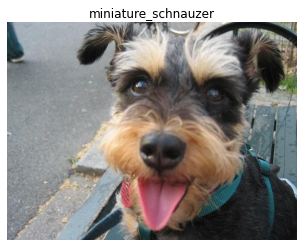

In [8]:
# let's plot a random image from our train dataset
dm.random_plot_enroll_data()

## Verificando os rótulos do problema de enroll

In [9]:
os.listdir('./../data/dogs/recognition/enroll')

['n02087394-Rhodesian_ridgeback',
 'n02090379-redbone',
 'n02092002-Scottish_deerhound',
 'n02093859-Kerry_blue_terrier',
 'n02094258-Norwich_terrier',
 'n02096294-Australian_terrier',
 'n02097047-miniature_schnauzer',
 'n02098286-West_Highland_white_terrier',
 'n02099429-curly-coated_retriever',
 'n02099601-golden_retriever',
 'n02102040-English_springer',
 'n02105056-groenendael',
 'n02106550-Rottweiler',
 'n02107683-Bernese_mountain_dog',
 'n02109961-Eskimo_dog',
 'n02111500-Great_Pyrenees',
 'n02111889-Samoyed',
 'n02113186-Cardigan',
 'n02113978-Mexican_hairless',
 'n02116738-African_hunting_dog']

In [10]:
dm.enroll_class_dict

{'West_Highland_white_terrier': 0,
 'groenendael': 1,
 'Scottish_deerhound': 2,
 'Kerry_blue_terrier': 3,
 'Rhodesian_ridgeback': 4,
 'African_hunting_dog': 5,
 'golden_retriever': 6,
 'Eskimo_dog': 7,
 'Norwich_terrier': 8,
 'Cardigan': 9,
 'English_springer': 10,
 'Samoyed': 11,
 'Great_Pyrenees': 12,
 'Bernese_mountain_dog': 13,
 'redbone': 14,
 'Australian_terrier': 15,
 'Mexican_hairless': 16,
 'Rottweiler': 17,
 'coated_retriever': 18,
 'miniature_schnauzer': 19}

## Carregando o melhor modelo para extrair as features

In [11]:
MODEL_CKPT_PATH = './../models/resnet-50'

In [12]:
model_ckpts = os.listdir(MODEL_CKPT_PATH)
losses = []
for model_ckpt in model_ckpts:
    loss = re.findall("\d+\.\d+", model_ckpt)
    losses.append(float(loss[0]))

losses = np.array(losses)
best_model_index = np.argsort(losses)[0]
best_model = model_ckpts[best_model_index]
print(best_model)

save-epoch=03-val_loss=0.44.ckpt


In [13]:
model = DogModel.load_from_checkpoint(MODEL_CKPT_PATH+'/'+best_model)

Use Pre-Training? True


A:\torch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Extraindo Features do *Train Enroll*

### Imagem insconsistente 

n02111889-Samoyed\\n02111889_3400.jpg

In [14]:
enroll_features, enroll_labels = feature_extractor(model, dm.enroll_dataloader())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [05:43<00:00,  8.82s/it]

features: 39, labels: 2444


In [15]:
dm.enroll_class_dict

{'West_Highland_white_terrier': 0,
 'groenendael': 1,
 'Scottish_deerhound': 2,
 'Kerry_blue_terrier': 3,
 'Rhodesian_ridgeback': 4,
 'African_hunting_dog': 5,
 'golden_retriever': 6,
 'Eskimo_dog': 7,
 'Norwich_terrier': 8,
 'Cardigan': 9,
 'English_springer': 10,
 'Samoyed': 11,
 'Great_Pyrenees': 12,
 'Bernese_mountain_dog': 13,
 'redbone': 14,
 'Australian_terrier': 15,
 'Mexican_hairless': 16,
 'Rottweiler': 17,
 'coated_retriever': 18,
 'miniature_schnauzer': 19}

In [16]:
_enroll_features = []

for batch in enroll_features:
    for image in batch:
        _enroll_features.append(image)

In [17]:
_enroll_features = np.asarray(_enroll_features, dtype=object)
enroll_labels = np.array(enroll_labels)

A:\torch\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.


In [18]:
enroll_features_labels = np.array([_enroll_features, enroll_labels, dm.enroll_class_dict])

A:\torch\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [19]:
file_path = './../data/resnet50-train_enroll_features.pickle'

with open(file_path, 'wb') as handle:
    pickle.dump(enroll_features_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Extraindo Features do *Test Enroll*

In [20]:
# Initialize our data pipeline
dm = DogDataModule(batch_size=64)

# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup(stage='test')

# Samples required by the custom ImagePredictionLogger callback to log image predictions.
test_samples = next(iter(dm.test_dataloader()))
test_imgs, test_labels = enroll_samples[0], enroll_samples[1]
test_imgs.shape, test_labels.shape

--------------------------------------------------
Images available for train/val: 17097
Classes available for train/val: 100

Images available for test: 1030
--------------------------------------------------
./../data/dogs/recognition/test/n02087394-Rhodesian_ridgeback\n02087394_101.jpg


(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [21]:
test_enroll_features, test_enroll_labels = feature_extractor(model, dm.test_dataloader())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [02:28<00:00,  8.76s/it]

features: 17, labels: 1030


In [22]:
dm.enroll_class_dict

{'West_Highland_white_terrier': 0,
 'groenendael': 1,
 'Scottish_deerhound': 2,
 'Kerry_blue_terrier': 3,
 'Rhodesian_ridgeback': 4,
 'African_hunting_dog': 5,
 'golden_retriever': 6,
 'Eskimo_dog': 7,
 'Norwich_terrier': 8,
 'Cardigan': 9,
 'English_springer': 10,
 'Samoyed': 11,
 'Great_Pyrenees': 12,
 'Bernese_mountain_dog': 13,
 'redbone': 14,
 'Australian_terrier': 15,
 'Mexican_hairless': 16,
 'Rottweiler': 17,
 'coated_retriever': 18,
 'miniature_schnauzer': 19}

In [23]:
_test_enroll_features = []

for batch in test_enroll_features:
    for image in batch:
        _test_enroll_features.append(image)

In [24]:
_test_enroll_features = np.asarray(_test_enroll_features, dtype=object)
test_enroll_labels = np.array(test_enroll_labels)

A:\torch\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.


In [25]:
test_enroll_features_labels = np.array([_test_enroll_features, test_enroll_labels, dm.enroll_class_dict])

A:\torch\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [26]:
file_path = './../data/resnet50-test_enroll_features_labels.pickle'

with open(file_path, 'wb') as handle:
    pickle.dump(test_enroll_features_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Extraindo Features da Validação (ideia utilizada para a classe *unknown*)

In [27]:
# Initialize our data pipeline
dm = DogDataModule(batch_size=64)

# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup(stage='fit')

# Samples required by the custom ImagePredictionLogger callback to log image predictions.
val_samples = next(iter(dm.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]
val_imgs.shape, val_labels.shape

--------------------------------------------------
Images available for train/val: 17097
Classes available for train/val: 100

Images available for test: 1030
--------------------------------------------------
./../data/dogs/train/n02088094-Afghan_hound\n02088094_5150.jpg
./../data/dogs/train/n02105412-kelpie\n02105412_5702.jpg


(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [28]:
validation_features, validation_labels = feature_extractor(model, dm.val_dataloader())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [09:05<00:00, 10.10s/it]

features: 54, labels: 3420


In [33]:
_validation_features = []

for batch in validation_features:
    for image in batch:
        _validation_features.append(image)

In [34]:
_validation_features = np.asarray(_validation_features, dtype=object)
validation_labels = np.asarray(validation_labels)

A:\torch\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.


In [35]:
validation_features_labels = np.array([_validation_features, validation_labels, dm.class_dict])

A:\torch\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [32]:
file_path = './../data/resnet50-validation_features_labels.pickle'

with open(file_path, 'wb') as handle:
    pickle.dump(validation_features_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)